In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import numpy as np
import cluster_toolkit as ct
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from astropy import constants, cosmology, units

In [2]:
import sys
sys.path.append('./support')
sys.path.append('../clmm')
import modeling as pp

#### Define a cosmology

In [3]:
# If CCL is installed, define a CCL cosmology object
# import pyccl as ccl
# cosmo_ccl = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)


# If CCL is not installed, use astropy instead with the following lines
from astropy.cosmology import FlatLambdaCDM
astropy_cosmology_object = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
cosmo_ccl = pp.cclify_astropy_cosmo(astropy_cosmology_object)

# Initializing NumCosmo
Ncm.cfg_init ()

cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm")
cosmo.omega_x2omega_k ()

cosmo.props.w       = -1.0
cosmo.props.H0 = cosmo_ccl['H0']

cosmo.param_set_by_name ("H0",     cosmo_ccl['H0'])
cosmo.param_set_by_name ("Omegab", cosmo_ccl['Omega_b'])
cosmo.param_set_by_name ("Omegac", cosmo_ccl['Omega_c'])
cosmo.param_set_by_name ("w",      -1.0)
cosmo.param_set_by_name ("Omegak",  0.0)
cosmo.param_set_by_name ("Tgamma0", 0.0)


#### Define the galaxy cluster model

In [5]:
# Select density profile and profile parametrization options 
density_profile_parametrization = 'nfw'
mass_Delta = 200      # Mass defintion: mean matter density
cluster_mass = 1.0e15 # Msun / h
cluster_concentration = 4.0
z    = 0.0
z_max = 3.0

# Correction factor for the critical mass density 
# NumCosmo uses the gravitational constant value, G, from CODATA 2018. 
# cluster_toolkit defines a macro for rho_c, which provides a different value in comparison to NumCosmo.
# This correction factor is applied to the cluster mass value.
cor_factor = 2.77533742639e+11 / Ncm.C.crit_mass_density_h2_solar_mass_Mpc3 ()

# NumCosmo Density profile
dp              = Nc.DensityProfileNFW.new (Nc.DensityProfileMassDef.MEAN, mass_Delta)
dp.props.MDelta = cluster_mass / cor_factor / cosmo.h ()
dp.props.c      = cluster_concentration

dist = Nc.Distance.new (z_max)
smd  = Nc.WLSurfaceMassDensity.new (dist)

smd.prepare (cosmo)

In [6]:
z_a     = np.linspace (0.01, 3.0, 1000)
a_a     = 1.0 / (1.0 + z_a)
Da_a    = pp.get_angular_diameter_distance_a (cosmo_ccl, a_a)
nc_Da_a = np.array ([dist.angular_diameter (cosmo, z) * cosmo.RH_Mpc () * 1.0e6 for z in  z_a])

#print (nc_Da_a / Da_a - 1.0)

In [7]:
cor_factor

0.9999896063922828

#### Quick test of all modeling function

### Function to make automatic comparisons

In [51]:
import pylab as plt
def compare(x, y_clmm, y_nc, x_name='x', y_name='func', subplots_pars={'figsize':(6, 4)}):
    clmm_name, nc_name = '%s_{clmm}'%y_name, '%s_{nc}'%y_name
    diff = y_nc/y_clmm - 1.
    print('rel diff min: %g\nrel diff max: %g'%(min(abs(diff)), max(abs(diff))))
    fig, axs = plt.subplots(2, sharex=True, **subplots_pars)
    fig.subplots_adjust(hspace=0)
    
    axs[0].plot(x, y_clmm, label='clmm', lw=3)
    axs[0].plot(x, y_nc, label='nc')
    axs[1].plot(x, diff, c='r')
    axs[1].axhline(0, ls=':', c='0', lw=.5)

    axs[0].legend()
    axs[0].set_ylabel('$%s$'%y_name)
    axs[1].set_xlabel('$%s$'%x_name)
    axs[1].set_ylabel('$%s/%s-1$'%(nc_name, clmm_name))
    
    return fig, axs

In [52]:
r3d = np.logspace(-2, 2, 100)

rel diff min: 1.14797e-13
rel diff max: 1.65251e-11


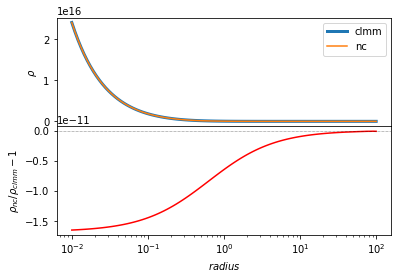

In [53]:
rho    = pp.get_3d_density(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, cosmo=cosmo_ccl)

nc_rho = np.array ([dp.eval_density (cosmo, r3d_i / cosmo.h (), z) * cor_factor / cosmo.h2 () for r3d_i in r3d])
#print (nc_rho / rho - 1.0)

fig, axs = compare(r3d, rho, nc_rho, x_name='radius', y_name='\\rho')
axs[0].set_xscale('log')

rel diff min: 1.15761e-09
rel diff max: 2.60993e-09


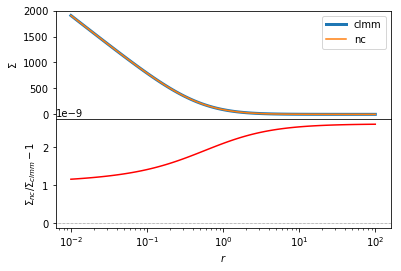

In [54]:
Sigma    = pp.predict_surface_density(r3d, cluster_mass, cluster_concentration, cosmo=cosmo_ccl, Delta=200, 
                                      halo_profile_parameterization='nfw')
nc_Sigma = np.array ([smd.sigma (dp, cosmo, r3d_i / cosmo.h (), z) * cor_factor / cosmo.h () / 1.0e12 for r3d_i in r3d])

fig, axs = compare(r3d, Sigma, nc_Sigma, x_name='r', y_name='\\Sigma')
axs[0].set_xscale('log')

rel diff min: 9.73073e-10
rel diff max: 3.49793e-09


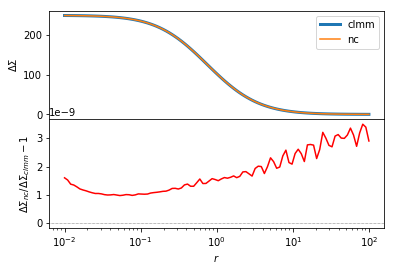

In [70]:
DeltaSigma    = pp.predict_excess_surface_density(r3d, cluster_mass, cluster_concentration, cosmo=cosmo_ccl, Delta=200, 
                                                  halo_profile_parameterization='nfw')
nc_SigmaMean  = np.array ([smd.sigma_mean (dp, cosmo, r3d_i / cosmo.h (), z) * cor_factor / cosmo.h () / 1.0e12 for r3d_i in r3d])
nc_DeltaSigma = nc_SigmaMean - nc_Sigma

fig, axs = compare(r3d, DeltaSigma, nc_DeltaSigma, x_name='r', y_name=r'\Delta\Sigma')
axs[0].set_xscale('log')

In [69]:
Sigmac = pp.get_critical_surface_density(cosmo_ccl, z_cluster=1.0, z_source=2.0)

nc_Sigmac = smd.sigma_critical (cosmo, 2.0, 1.0, 1.0) / 1.0e12

print (Sigmac, nc_Sigmac, Sigmac / nc_Sigmac - 1.0)

2689.2868411957415 2689.286841010555 6.886091696856056e-11


rel diff min: 2.20426e-10
rel diff max: 1.80317e-09


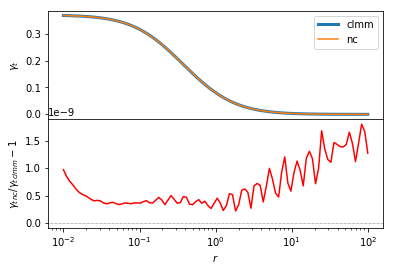

In [89]:
gammat    = pp.predict_tangential_shear(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, z_cluster=1.0, 
                                        z_source=2.0, cosmo=cosmo_ccl, Delta=int (200 * 8), 
                                        halo_profile_parameterization='nfw', z_src_model='single_plane')

# In the smd.shear method NumCosmo computes DeltaSigma at the cluster redshift while CLMM computes at z = 0
nc_gammat = np.array ([smd.shear (dp, cosmo, r3d_i / cosmo.h (), 2.0, 1.0, 1.0) for r3d_i in r3d]) * cor_factor / cosmo.h () 
# Here we redo the computation to match CLMM results
#nc_gammat = nc_DeltaSigma / nc_Sigmac

fig, axs = compare(r3d, gammat, nc_gammat, x_name='r', y_name=r'{\gamma_t}')
axs[0].set_xscale('log')

rel diff min: 0.00530896
rel diff max: 1.29667


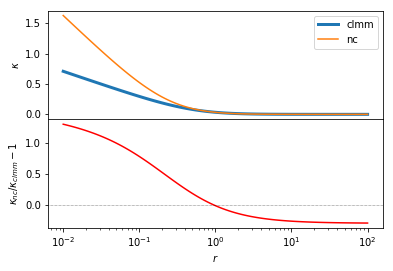

In [79]:
kappa = pp.predict_convergence(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=1.0, z_source=2.0,
                               cosmo=cosmo_ccl, Delta=200, 
                               halo_profile_parameterization='nfw', 
                               z_src_model='single_plane')
nc_kappa = np.array ([smd.convergence (dp, cosmo, r3d_i / cosmo.h (), 2.0, 1.0, 1.0) for r3d_i in r3d])

fig, axs = compare(r3d, kappa, nc_kappa, x_name='r', y_name=r'\kappa')
axs[0].set_xscale('log')


In [12]:
gt = pp.predict_reduced_tangential_shear(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                                         z_cluster=1.0, z_source=2.0, cosmo=cosmo_ccl, Delta=200, 
                                         halo_profile_parameterization='nfw', z_src_model='single_plane')
        

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_profile(r, profile_vals, profile_label='rho'):
    plt.loglog(r, profile_vals)
    plt.xlabel('r [Mpc]', fontsize='xx-large')
    plt.ylabel(profile_label, fontsize='xx-large')

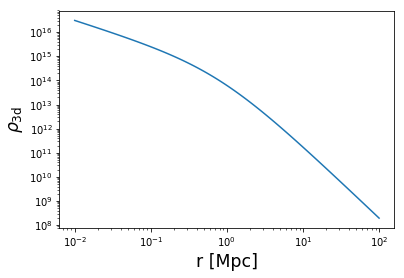

In [14]:
plot_profile(r3d, rho, '$\\rho_{\\rm 3d}$')

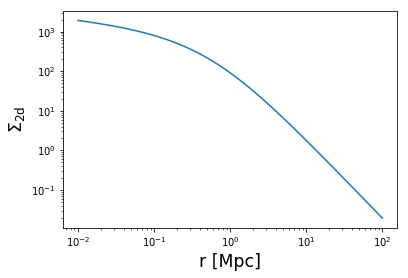

In [15]:
plot_profile(r3d, Sigma, '$\\Sigma_{\\rm 2d}$')

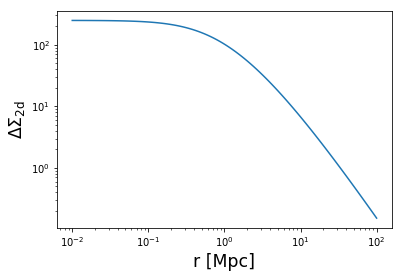

In [16]:
plot_profile(r3d, DeltaSigma, '$\\Delta\\Sigma_{\\rm 2d}$')

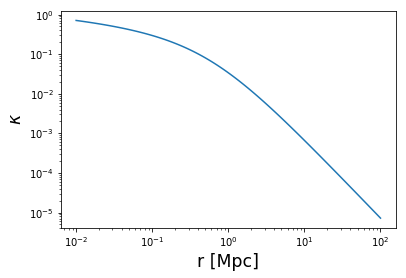

In [17]:
plot_profile(r3d, kappa, '$\\kappa$')

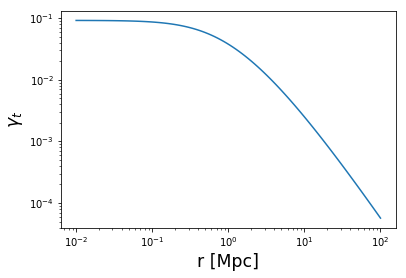

In [18]:
plot_profile(r3d, gammat, '$\\gamma_t$')

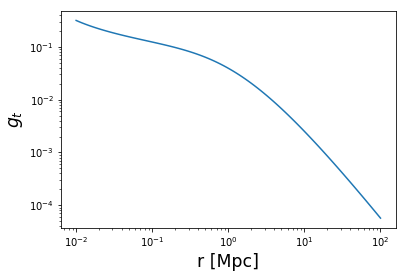

In [19]:
plot_profile(r3d, gt, '$g_t$')